In [47]:
from numpy import random, sqrt, log, sin, cos, pi

# transformation function
def gaussian(u1,u2):
    z1 = sqrt(-2*log(u1))*cos(2*pi*u2)
    z2 = sqrt(-2*log(u1))*sin(2*pi*u2)
    return z1,z2

# uniformly distributed values between 0 and 1
u1 = random.rand(100000)
u2 = random.rand(100000)

# run the transformation
z1,z2 = gaussian(u1,u2)

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [122]:
class env:
    """
    The evironment where we can generate simulation pathes,define trading cost, etc

    """
    def __init__(self,H,sigma,p_e,length,TickSize,LotSize,k, MAX_PRICE):
        
        """
        H - 
        sigma: the val
        p_e : equilibrim price
        lenth : the length of the path
        TickSize: tck size
        LotSize  : lot size
        k         : kappa, mean-variance parameter
        MAX_PRICE : maximum price
        """
        
        self.H = H
        self.sigma = sigma
        self.p_e = p_e
        self.length = length
        self.TickSize = TickSize
        self.LotSize = LotSize
        self.k = k
        self.MAX_PRICE = MAX_PRICE
    
    def GeneratePath(self):
        """
        Generate the simulation path
        
        """
        self._lambda = np.log(2)/self.H
        x_t = 0
        p_t = [self.p_e/self.TickSize]
        count = 0
        for i in range(self.length):
            # generate price step by setp
            x_t+=-self._lambda*x_t+self.sigma*np.random.normal()
            
            #if it is larger than the uppder bound, then bound it.
            if x_t>np.log(self.MAX_PRICE/self.p_e):
                p_t.append(self.MAX_PRICE/self.TickSize)
                x_t = np.log(self.MAX_PRICE/self.p_e)
                count+=1
            else:
                p_t.append(int(self.p_e*np.exp(x_t)/self.TickSize))
\
        return p_t
    
    def SpreadCost(self,DeltaN):
        """
        Spread cost as defined
        """
        return self.TickSize*abs(DeltaN)*self.LotSize
    
    def ImpactCost(self,DeltaN):
        """
        market impact as define
        """
        return abs(DeltaN)**2*self.TickSize*self.LotSize
    
    def Reward(self,state1,state2):
        """
        reward we want to optimize
        """
        delta_v = state2[1]*(state2[0]-state1[0])*self.LotSize*self.TickSize \
        -self.SpreadCost(state2[1]-state1[1])-self.ImpactCost(state2[1]-state1[1])
        return delta_v-0.5*self.k*delta_v**2
        
        

In [123]:
class QLearningTable:
    def __init__(self, positions, learning_rate, reward_decay,epsilon_greedy,K,M,_env):
        """
        The Q learning agent
        position : array-like variable, indicate holdling
        learning_rate,reward_decay,epsilon_greedy: Q learning parameter
        K: maximun size of trade at each step
        M: maximum holding position
        _env : environemnet as define above.
        self.q_table: PRICE * POSITION table
        """
        self.positions = positions  # a list
        self.lr = learning_rate
        self.gamma = reward_decay
        self.q_table = pd.DataFrame(columns=self.positions,index = range(1,1001))
        self.epsilon = epsilon_greedy
        self.K = K
        self.M = M
        self.env = _env
        self.fitted = False
        
        # initialize the (Price/ticke size) x  (position) table:
        # the element of the table is the action(at most 2*k + 1 actions to be taken)
        for i in range(1,self.env.MAX_PRICE*10+1):
            for j in self.positions:
                self.q_table.loc[i,j] = [0]*(2*self.K+1)
    
    def get_index(self,s):
        """
        Function that ret turn the indexs of the available actions(the action with maximum reward in next step)
        return type: list
        """
        _ind = []
        _max = max(s)
        for i in range(0,len(s)):
            if s[i] == _max:
                _ind.append(i)
        return _ind
    
    def choose_action(self, state):
        
        """
        The update function for Q learning
        state = [price,holding]
        
        """
        
        # left bound of available action, given hoding (in state[])
        lb = self.K+max(-self.M,state[1]-self.K)-state[1]
        rb = self.K+1+min(self.M,state[1]+self.K)-state[1]
        
        
        if np.random.uniform() < self.epsilon:
            
            #Fist we take all protential action from the price- holding table : self.q_table.loc[state[0], state[1]]
            #Given my holding,holding limit M and buying limit K, only actions between lb and rb can be chosen 
            
            state_action = self.q_table.loc[state[0], state[1]][lb:rb]
            
            # find the action that have the maximum reward expectations
            _ind = self.get_index(state_action) 
            # if there are more than 1 this kind of action, we are going to randomly chose one from them
            if len(_ind)>1:   
                np.random.shuffle(_ind)
            action = _ind[0]+lb
        #randomly choose an action
        else:
           
            action = np.random.choice(range(lb,rb))
       
        return action

    def learn(self,s,a,s_):
        """
        function that update the Q_table
        s : the state before price and holding are changed
        s_: the state after price and holding are changed
        a : action we take in state s(before changing)
        
        """
        # boundary in action, so that holding won't excess limit
        lb = self.K+max(-self.M,s_[1]-self.K)-s_[1]
        rb = self.K+1+min(self.M,s_[1]+self.K)-s_[1]
        
        
        # the expectation of reward by takeing action a
        q_predict = self.q_table.loc[s[0], s[1]][a]
        
        # the function for Q learning after we saw the changes
        q_target = self.env.Reward(s,s_) \
        + self.gamma * max(self.q_table.loc[s_[0],s_[1]][lb:rb]) 
        
        # update Q table
        self.q_table.loc[s[0], s[1]][a] += self.lr * (q_target - q_predict)  

            
    def fit(self,initial_point):
        """
        fit our table given a starting price and holding
        initial_point: starting price and holding
        
        
        """
        self.fitted = True
        s = initial_point
        price = self.env.GeneratePath()
        for i in range(1,len(price)):
            #print(s)
            action = self.choose_action(s)
            s_ = (price[i],s[1]+action-self.K)
            self.learn(s,action,s_)
            s = s_
            if i%(10**5) == 0:
                print(i/(10**5))
    
    def q_table(self):
        """
        get the table
        """
        assert self.fitted
        return self.q_table

In [124]:
class TestQtable:
    """
    where we test our result
    
    
    """
    def __init__(self,env,q_table):
        """
        initialize the testing with a given environment and an empty q-table
        
        """
        self.env = env
        self.q_table = q_table
        self.profit = [0]
    
    def StepProfit(self,s,s_):
        """
        Function that calculate the profit after trading cost
        """
        delta_v = s_[1]*(s_[0]-s[0])*self.env.LotSize*self.env.TickSize\
        -self.env.SpreadCost(s_[1]-s[1])-self.env.ImpactCost(s_[1]-s[1])
        return delta_v
    
    def test(self,initial_point):
        """
        Generate path and learn it step by step
        """
        price = self.env.GeneratePath()
        plt.plot(price)
        plt.show()
        s = initial_point
        for p in price[1:]:
            action = self.q_table.choose_action(s)
            s_ = (p,s[1]+action-self.q_table.K)
            self.profit.append(self.profit[-1]+ self.StepProfit(s,s_))
            s = s_
        
    def TotalProfit(self):
        """
        out-put the total profit
        """
        return self.profit

In [158]:
action = range(-10,11)
env1 = env(5,0.1,50,10**7,0.1,100,10**(-4),120)

In [159]:
model = QLearningTable(action,0.001,0.999,0.9,5,10,env1)

In [160]:
model.fit((500,0))

37
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0
84.0
85.0
86.0
87.0
88.0
89.0
90.0
91.0
92.0
93.0
94.0
95.0
96.0
97.0
98.0
99.0
100.0


In [161]:
env2 = env(5,0.1,50,5000,0.1,100,10**(-4),200)

In [162]:
test = TestQtable(env2,model)

0


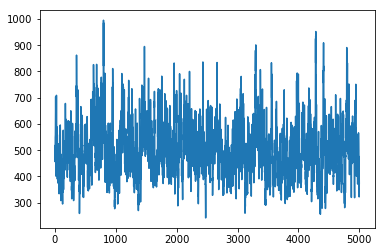

In [163]:
test.test((500,0))

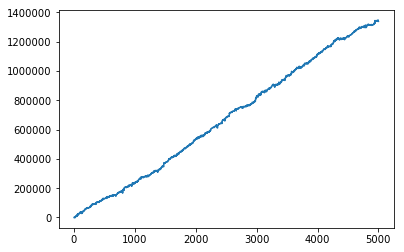

In [164]:
plt.plot(test.profit)
plt.show()